# Определение перспективного тарифа для телеком компании

## Изучение общей информации

### Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». В нашем распоряжении выборка из 500 клиентов. Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше, а также предоставить информацию о том, какой тариф приносит больше денег.

Сделаем импорт необходимых библиотек:

In [4]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import norm
pd.set_option('display.max_columns', 100)




С помощью функции overview ознакомимся с каждой из таблиц:

In [5]:
def overview(data):
    print(data.info()) 
    return data.head(10)

In [6]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
overview(data_tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Описание таблицы tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

В этой таблице ничего примечательного, с данными все в порядке.

In [7]:
data_users = pd.read_csv('/datasets/users.csv')
overview(data_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


**Описание таблицы users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Видим пропуски NaN в столбце churn_date, также необходимо изменить формат в столбцах churn_date и reg_date на datetime.

In [8]:
data_calls = pd.read_csv('/datasets/calls.csv')
overview(data_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


**Описание таблицы calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Необходимо изменить формат на datetime в столбце call_date. В столбце duration необходимо разобраться с 0, округлить значения до целого числа в большую сторону.


In [9]:
data_messages = pd.read_csv('/datasets/messages.csv')
overview(data_messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


**Описание таблицы messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Необходимо столбец message_date изменить на формат datetime.

In [10]:
data_internet = pd.read_csv('/datasets/internet.csv')
overview(data_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


**Описание таблицы internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Необходимо столбец session_date изменить на формат datetime. В столбце mb_used  округлить значения до целого числа в большую сторону. В таблице data_internet есть столбец "Unnamed: 0", который повторяет индексы строк. Его можно удалить.

### Выводы:

Сложностей в форматировании данных и замене пропусков нет. Необходимо удалить столбец "Unnamed: 0" в таблице интернета. Далее округлим значения в некоторых столбцах до целового значения в большую сторону, приведем даты в более удобный вид и разберемся с нулями.



## Подготовка данных


Удалим столбец "Unnamed: 0", повторяющий индексы строк.

In [11]:
del data_internet['Unnamed: 0']

In [12]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB



В столбце churn_date заполним пропуски верхней границей по дате - 31 декабря 2018 года, т.к. нам интересен только 2018 год.


In [13]:
data_users['churn_date'] = data_users['churn_date'].fillna('2018-12-31')

Для изменения формата даты на datetime во всех столбцах напишем функцию changed_date.

In [14]:
def changed_date(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')

In [15]:
changed_date(data_calls, 'call_date')
changed_date(data_internet, 'session_date')
changed_date(data_messages, 'message_date')
changed_date(data_users, 'reg_date')
changed_date(data_users, 'churn_date')

Для примера проверим data_users результат:

In [16]:
overview(data_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,2018-12-31,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,2018-12-31,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,2018-12-31,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,2018-12-31,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,2018-12-31,Пермь,Василиса,Блинова,2018-03-22,smart



Сделаем проверку в таблице data_calls количества звонков с нулевым значением.

In [17]:
data_calls[data_calls['duration'] == 0]['duration'].count()

39613

Присутствие значений в таблице говорит о том, что звонок был совершен. Этот оператор сотовой связи использует поминутную тарификацию, значит значения округляются до минуты в большую сторону. Следовательно, заменим 0 минут на 1 минуту.

In [18]:
data_calls['duration'] = data_calls['duration'].replace(0, 1)

В столбцах значения с минутами разговора и траффиком интернета округлим до целого значения в большую сторону.



In [19]:
data_calls['duration'] = data_calls['duration'].apply(np.ceil)
data_internet['mb_used'] = data_internet['mb_used'].apply(np.ceil)

Сделаем проверку.


In [20]:
overview(data_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,1.0,1000
1,1000_1,2018-08-17,1.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
5,1000_5,2018-11-02,1.0,1000
6,1000_6,2018-10-18,1.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
9,1000_9,2018-08-15,1.0,1000


In [21]:
overview(data_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
5,1000_5,400.0,2018-10-02,1000
6,1000_6,541.0,2018-09-07,1000
7,1000_7,416.0,2018-07-11,1000
8,1000_8,506.0,2018-10-08,1000
9,1000_9,346.0,2018-09-03,1000


C помощью метода .duplicated() проверим таблицы на дубликаты:

In [22]:
[data.duplicated().sum() for data in (data_calls, data_messages, data_internet, data_users)]

[0, 0, 0, 0]

В столбцах, где присутствуют даты, добавим столбцы с месяцами для дальнейшей работы. Используем для этого функцию append_month:

In [23]:
def append_month(data, date):
    data['month'] = data[date].dt.month

In [24]:
append_month(data_calls, 'call_date')
append_month(data_internet, 'session_date')
append_month(data_messages, 'message_date')

Сделаем проверку на примере data_messages:

In [25]:
data_messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


Сделаем срез из столбцов 'tariff' и 'user_id', затем добавим новый столбец 'registration_month', чтобы знать с какого месяца используется тариф.

In [26]:
user_tariff = data_users.loc[:, ['user_id', 'tariff']]
user_tariff['registration_month'] = data_users['reg_date'].dt.month
user_tariff

,user_id,tariff,registration_month
0,1000,ultra,5
1,1001,smart,11
2,1002,smart,6
3,1003,ultra,8
4,1004,ultra,5
...,...,...,...
495,1495,ultra,8
496,1496,smart,1
497,1497,smart,10
498,1498,smart,7



### Количество использованных минут разговора и сделанных звонков по месяцам 

 Сделаем свод по звонкам, чтобы произвести расчет количества совершенных звонков и использованных минут по месяцам. Операцию выполним с помощью методов count и sum. Также для удобства заменим пропуски пробелами.

In [27]:
calls_by_month = data_calls.pivot_table(
    index=['user_id', 'month'], 
    values='duration', 
    aggfunc=['count','sum']
).reset_index()

In [28]:
calls_by_month

,user_id,month,count,sum
,,,duration,duration
0,1000,5,22,164.0
1,1000,6,43,187.0
2,1000,7,47,346.0
3,1000,8,52,418.0
4,1000,9,58,478.0
...,...,...,...,...
3169,1498,10,41,258.0
3170,1499,9,9,71.0
3171,1499,10,68,473.0


### Количество исходящих сообщений по месяцам

Сделаем свод по количеству исходящих сообщений по месяцам с помощью метода count. Также для удобства заменим пропуски пробелами.

In [30]:
sms_by_month = data_messages.pivot_table(index=['user_id'], columns='month', values='message_date', aggfunc='count')
sms_by_month.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,22,60,75,81,57,73,58,70
1002,,,,,,4,11,13,4,10,16,12
1003,,,,,,,,37,91,83,94,75
1004,,,,,95,134,181,151,146,165,158,162
1005,7,38,56,41,42,47,56,64,52,44,51,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,13,82,82,79,84
1496,9,45,46,49,40,35,42,41,29,35,46,51
1497,,,,,,,,,,20,14,17



### Количество использованного трафика интернета по месяцам



Сделаем свод по трафику интернета, чтобы произвести потраченный объем по месяцам. Операцию выполним с помощью метода sum. Для удобства заменим пропуски пробелами.

In [31]:
inet_by_month = data_internet.pivot_table(index=['user_id'], columns='month', values='mb_used', aggfunc='sum')
inet_by_month.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,2256,23257,14016,14070,14581,14717,14768,9827
1001,,,,,,,,,,,18452,14053
1002,,,,,,10871,17601,20347,16712,13905,18610,18137
1003,,,,,,,,8571,12479,14779,11368,10132
1004,,,,,13415,17619,22243,28607,15125,18494,15631,18038
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,2616,33105,29393,38972,23450
1496,3766,28523,24990,21098,23740,20163,24395,23560,26970,28215,25092,20757
1497,,,,,,,,,,11512,14174,19940


### Помесячная выручка с каждого пользователя




Сделаем свод со звонками, трафиком и сообщениями, чтобы рассчитать выручку с каждого пользователя.

In [32]:
calls_by_month = data_calls.pivot_table(index=['user_id'], columns='month', values='duration', aggfunc='sum')
calls_inet_sms =  (user_tariff.merge(calls_by_month, on='user_id', how='left')
                         .merge(inet_by_month, on='user_id', how='left')
                         .merge(sms_by_month, on='user_id', how='left')
             )
calls_inet_sms


,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,5,NaN,NaN,NaN,NaN,164.0,187.0,346.0,418.0,478.0,363.0,344.0,341.0,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,smart,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,444.0,430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,smart,6,NaN,NaN,NaN,NaN,NaN,118.0,219.0,294.0,217.0,221.0,250.0,242.0,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,392.0,990.0,866.0,844.0,822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
4,1004,ultra,5,NaN,NaN,NaN,NaN,37.0,177.0,137.0,138.0,125.0,153.0,121.0,136.0,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,830.0,1056.0,971.0,1066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616.0,33105.0,29393.0,38972.0,23450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
496,1496,smart,1,49.0,606.0,569.0,536.0,497.0,572.0,592.0,553.0,496.0,466.0,676.0,533.0,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
497,1497,smart,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0,387.0,558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11512.0,14174.0,19940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
498,1498,smart,7,NaN,NaN,NaN,NaN,NaN,NaN,178.0,414.0,477.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7486.0,24270.0,22166.0,20604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


Сделаем разделение данной таблицы на тарифы «Смарт» и «Ультра». Создадим датафреймы.

In [33]:
smart_clients = calls_inet_sms[calls_inet_sms['tariff'] == 'smart']
ultra_clients = calls_inet_sms[calls_inet_sms['tariff'] == 'ultra']
smart_clients = pd.DataFrame(smart_clients)
ultra_clients = pd.DataFrame(ultra_clients)


Для удобства написания функций вызовем data_tariffs:

In [34]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Произведем расчет расходов пользователей тарифа «Ультра», после чего с помощью циклов посмотрим каждый столбец с минутами, сообщениями и трафиком на наличие сверх лимита по тарифу и сделаем расчет доп.стоимости.

In [35]:
def ultra_val_calls(value):
        if value > data_tariffs.loc[1, 'minutes_included']:
            cost = (value - data_tariffs.loc[1, 'minutes_included']) * data_tariffs.loc[1, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def ultra_val_inet(value):
        if value > data_tariffs.loc[1, 'mb_per_month_included']:
            cost = (value - data_tariffs.loc[1, 'mb_per_month_included']) / 1024 * data_tariffs.loc[1, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    

def ultra_val_sms(value):
        if value > data_tariffs.loc[1, 'messages_included']:
            cost = (value - data_tariffs.loc[1, 'messages_included']) * data_tariffs.loc[1, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    ultra_clients[str(i)+'_x'] = ultra_clients[str(i)+'_x'].apply(ultra_val_calls)
for i in range(1,13):
    ultra_clients[str(i)+'_y'] = ultra_clients[str(i)+'_y'].apply(ultra_val_inet)
for i in range(1,13):
    ultra_clients[i] = ultra_clients[i].apply(ultra_val_sms)
ultra_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
3,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
13,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
16,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
485,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
491,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
493,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1766.015625,0,0,0,0,0,0,0,0,0,0,0,0


Добавим столбцы с ежемесячной платой, но cперва присвоим им значение месяца регистрации.


In [36]:
for i in range(1,13):
    ultra_clients[str(i)+'_fee'] = ultra_clients['registration_month']
ultra_clients = ultra_clients.reset_index(drop=True)

С помощью цикла сделаем так: если значение месяца больше или равно месяца регистрации, то произведем замену на ежемесячную оплату, иначе. Таким образом для каждого пользователя получим месяцы владения.

In [37]:
for j in range (0, len(ultra_clients)):  
    for i in range(1,13):
        if i >= ultra_clients.loc[j, str(i) + '_fee']:
            ultra_clients.loc[j, str(i) + '_fee'] = data_tariffs.loc[1, 'rub_monthly_fee']
        else:
            ultra_clients.loc[j, str(i) + '_fee'] = 0
ultra_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
2,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950
146,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1766.015625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950



С помощью цикла произведем суммирование доп.платы за звонки, сообщения и трафик и ежемесячную плату для каждого клиента.

In [38]:
for i in range(1,13):
    ultra_clients[str(i) + '_total'] = ultra_clients[str(i)+'_x'] + ultra_clients[str(i)+'_y'] + ultra_clients[i] + ultra_clients[str(i) + '_fee']
ultra_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
1,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
2,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1950.000000
146,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1766.015625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,3716.015625




Из прошлой таблицы нам необходимы только тариф, дата регистрации, ежемесячные траты и id пользователя. Сделаем срез. Для удобства преобразуем в целочисленные значения.

In [39]:
ultra_general = ultra_clients[['user_id', 'tariff', 'registration_month', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
ultra_general = pd.DataFrame(ultra_general)

for i in range (1,13):
    ultra_general[str(i) + '_total'] = ultra_general[str(i) + '_total'].astype('int')
ultra_general

,user_id,tariff,registration_month,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1003,ultra,8,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
2,1004,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,1950
146,1491,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,3716


Теперь эти же операции проделаем и для клиентов тарифа "Смарт".

In [40]:
def smart_val_calls(value):
        if value > data_tariffs.loc[0, 'minutes_included']:
            cost = (value - data_tariffs.loc[0, 'minutes_included']) * data_tariffs.loc[0, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def smart_val_inet(value):
        if value > data_tariffs.loc[0, 'mb_per_month_included']:
            cost = (value - data_tariffs.loc[0, 'mb_per_month_included']) / 1024 * data_tariffs.loc[0, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    

def smart_val_sms(value):
        if value > data_tariffs.loc[0, 'messages_included']:
            cost = (value - data_tariffs.loc[0, 'messages_included']) * data_tariffs.loc[0, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    smart_clients[str(i)+'_x'] = smart_clients[str(i)+'_x'].apply(smart_val_calls)
for i in range(1,13):
    smart_clients[str(i)+'_y'] = smart_clients[str(i)+'_y'].apply(smart_val_inet)
for i in range(1,13):
    smart_clients[i] = smart_clients[i].apply(smart_val_sms)
smart_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
1,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,603.906250,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,437.695312,974.023438,264.062500,0.000000,634.765625,542.382812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0
6,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,380.664062,0.000000,0.00000,0.000000,906.250000,774.804688,35.742188,851.953125,0.000000,612.890625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,458.59375,0.000000,62.500000,1047.460938,0.000000,0.000000,201.171875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,317.578125,475.390625,530.468750,446.289062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2570.898438,1880.859375,1120.703125,1636.71875,938.085938,1764.648438,1601.562500,2267.578125,2510.742188,1900.781250,1054.101562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
497,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,894.531250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1740.234375,1329.296875,1024.218750,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0


In [41]:
for i in range(1,13):
    smart_clients[str(i)+'_fee'] = smart_clients['registration_month']
smart_clients = smart_clients.reset_index(drop=True)

In [42]:
for j in range (0, len(smart_clients)):  
    for i in range(1,13):
        if i >= smart_clients.loc[j, str(i) + '_fee']:
            smart_clients.loc[j, str(i) + '_fee'] = data_tariffs.loc[0, 'rub_monthly_fee']
        else:
            smart_clients.loc[j, str(i) + '_fee'] = 0
smart_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,603.906250,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,550,550
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,437.695312,974.023438,264.062500,0.000000,634.765625,542.382812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,550,550,550,550,550,550,550
2,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,550,550,550,550,550,550,550,550,550,550,550,550
3,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,380.664062,0.000000,0.00000,0.000000,906.250000,774.804688,35.742188,851.953125,0.000000,612.890625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,550,550,550,550,550,550,550,550,550,550,550
4,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,458.59375,0.000000,62.500000,1047.460938,0.000000,0.000000,201.171875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,550,550,550,550,550,550,550,550,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,317.578125,475.390625,530.468750,446.289062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,550,550,550,550,550
347,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2570.898438,1880.859375,1120.703125,1636.71875,938.085938,1764.648438,1601.562500,2267.578125,2510.742188,1900.781250,1054.101562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,550,550,550,550,550,550,550,550,550,550,550,550
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,894.531250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,550,550,550
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1740.234375,1329.296875,1024.218750,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,550,550,550,550,550,550


In [43]:
for i in range(1,13):
    smart_clients[str(i) + '_total'] = smart_clients[str(i)+'_x'] + smart_clients[str(i)+'_y'] + smart_clients[i] + smart_clients[str(i) + '_fee']
smart_clients

,user_id,tariff,registration_month,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,603.906250,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,550,550,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1153.906250,550.000000
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,437.695312,974.023438,264.062500,0.000000,634.765625,542.382812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,550,550,550,550,550,550,550,0.0,0.000000,0.000000,0.000000,0.00000,550.000000,987.695312,1524.023438,814.062500,550.000000,1184.765625,1092.382812
2,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,550,550,550,550,550,550,550,550,550,550,550,550,550.0,550.000000,928.000000,1258.000000,868.00000,919.000000,820.000000,970.000000,556.000000,1285.000000,739.000000,901.000000
3,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,380.664062,0.000000,0.00000,0.000000,906.250000,774.804688,35.742188,851.953125,0.000000,612.890625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,550,550,550,550,550,550,550,550,550,550,550,0.0,550.000000,930.664062,550.000000,550.00000,550.000000,1456.250000,1324.804688,585.742188,1401.953125,550.000000,1162.890625
4,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,458.59375,0.000000,62.500000,1047.460938,0.000000,0.000000,201.171875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,550,550,550,550,550,550,550,550,550,0.0,0.000000,0.000000,550.000000,1008.59375,724.000000,879.500000,1597.460938,1072.000000,550.000000,1033.171875,550.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,317.578125,475.390625,530.468750,446.289062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,550,550,550,550,550,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,550.000000,897.578125,1025.390625,1080.468750,996.289062
347,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2570.898438,1880.859375,1120.703125,1636.71875,938.085938,1764.648438,1601.562500,2267.578125,2510.742188,1900.781250,1054.101562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,550,550,550,550,550,550,550,550,550,550,550,550,550.0,3438.898438,2637.859375,1778.703125,2186.71875,1704.085938,2590.648438,2310.562500,2817.578125,3060.742188,2978.781250,1706.101562
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,894.531250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,550,550,550,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,568.000000,550.000000,1618.531250
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1740.234375,1329.296875,1024.218750,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,550,550,550,550,550,550,0.0,0.000000,0.000000,0.000000,

In [44]:
smart_general = smart_clients[['user_id', 'tariff', 'registration_month', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
smart_general = pd.DataFrame(smart_general)

for i in range (1,13):
    smart_general[str(i) + '_total'] = smart_general[str(i) + '_total'].astype('int')
smart_general

,user_id,tariff,registration_month,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1001,smart,11,0,0,0,0,0,0,0,0,0,0,1153,550
1,1002,smart,6,0,0,0,0,0,550,987,1524,814,550,1184,1092
2,1005,smart,1,550,550,928,1258,868,919,820,970,556,1285,739,901
3,1006,smart,2,0,550,930,550,550,550,1456,1324,585,1401,550,1162
4,1007,smart,4,0,0,0,550,1008,724,879,1597,1072,550,1033,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0,0,0,0,0,0,0,550,897,1025,1080,996
347,1496,smart,1,550,3438,2637,1778,2186,1704,2590,2310,2817,3060,2978,1706
348,1497,smart,10,0,0,0,0,0,0,0,0,0,568,550,1618
349,1498,smart,7,0,0,0,0,0,0,550,2326,1879,1574,550,550


### Выводы:

Мы заполнили пропуски и изменили формат данных, тем самым, сделав данные удобные для дальнейшего исследования.
По пользователям тарифов "Смарт" и "Ультра" получили два датафрейма, исходя из которых уже видно невооруженным глазом различие между собой.

## Анализ данных

Для каждого тарифа построим по 3 таблицы (звонки, сообщения, интернет трафик). Это необходимо, чтобы иметь описание поведения клиентов оператора.

In [45]:
users_calls = user_tariff.merge(calls_by_month, on='user_id', how='left')
users_inet = user_tariff.merge(inet_by_month, on='user_id', how='left')
users_sms = user_tariff.merge(sms_by_month, on='user_id', how='left')

smart_users_calls = users_calls.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_calls = users_calls.query('tariff == "ultra"').reset_index(drop=True).fillna(0)
smart_users_inet = users_inet.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_inet = users_inet.query('tariff == "ultra"').reset_index(drop=True).fillna(0)
smart_users_sms = users_sms.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_sms = users_sms.query('tariff == "ultra"').reset_index(drop=True).fillna(0)

Напишем функции: 
- add_mean - добавляет столбец "Среднее по месяцам" для каждого пользователя 
- boxplot_values - возвращает значения диаграммы размаха
- mean_var_std - возвращает среднее, дисперсию, стандартное отклонение и доверительный интервал [-2σ: +2σ]
- plot_and_box - строит распределение и диаграмму размаха
- plots_and_values - запускает все вышеперечисленные функции

In [46]:
def add_mean(df):
    df['mean'] = sum(df[i] for i in range(1, 13)) / (13 - df['registration_month'])

add_mean(smart_users_calls)
add_mean(ultra_users_calls)
add_mean(smart_users_inet)
add_mean(ultra_users_inet)
add_mean(smart_users_sms)
add_mean(ultra_users_sms)

In [47]:
def boxplot_values(df, column):
    upper_quartile = df[column].quantile(.75)
    lower_quartile = df[column].quantile(.25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = df[column][df[column] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = df[column][df[column] >= lower_quartile - 1.5 * iqr].min()
    median = df[column].median()
    print ('Нижний квартиль: {:.1f}'.format(lower_quartile), '\n' 
           'Верхний квартиль: {:.1f}'.format(upper_quartile), '\n'
           'Нижний "ус": {:.1f}'.format(lower_whisker), '\n'
           'Верхний "ус": {:.1f}'.format(upper_whisker), '\n'
           'Медиана: {:.1f}'.format(median)
          )

In [48]:
def mean_var_std(df, column):
    mean = np.mean(df[column])
    variance = np.var(df[column], ddof=1)
    standard_deviation = np.std(df[column], ddof=1)
    bottom_line = mean - standard_deviation * 2
    top_line= mean + standard_deviation * 2
    print ('Среднее: {:.1f}'.format(mean), '\n' 
           'Дисперсия: {:.1f}'.format(variance), '\n'
           'Стандартное отклонение: {:.1f}, интервал 95% [-2σ: +2σ]: {:.1f} - {:.1f}'.format(standard_deviation, bottom_line, top_line)
          )

In [49]:
def plot_and_box(df, column):
    fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(17,7))
    ax.yaxis.tick_right()

    (df[column].plot(y=column, style='o', c='r', grid= True, legend=False, ax=ax)
                             .set(xlabel='Количество значений', ylabel='Среднее по пользователю'))
    df.boxplot(column=column, ax=ax2).set(xlabel='Диаграмма размаха')
    sns.distplot(df[column], ax=ax3, vertical=True).set(xlabel='Плотность частоты');

In [50]:
def plots_and_values(df, column):
    plot_and_box(df, column), boxplot_values(df, column), mean_var_std(df, column)

Вызовем функцию plots_and_values для всех исследуемых параметров.

### Звонки

Нижний квартиль: 319.7 
Верхний квартиль: 530.8 
Нижний "ус": 11.9 
Верхний "ус": 743.8 
Медиана: 434.6
Среднее: 427.2 
Дисперсия: 23384.7 
Стандартное отклонение: 152.9, интервал 95% [-2σ: +2σ]: 121.3 - 733.0


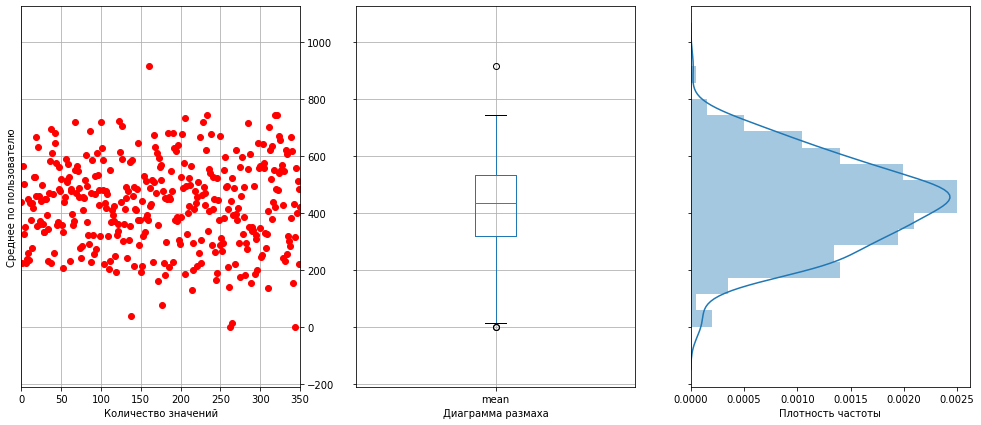

In [51]:
plots_and_values(smart_users_calls, 'mean')

У клиентов тарифа "Смарт" наблюдаем следующую картину:

- По звонкам среднее и медиана почти равны и расстояние от медианы до первого и третьего квартиля также почти равны, поэтому можно судить о нормальном распределении без каких-либо сдвигов;

- Из диаграммы размаха следует, что присутствуют аномально низкие значения (менее 12 минут) и аномально высокие значения (больше 744 минут) в месяц соответственно.

- 95% значений находится в доверительном интервале от 121.3 до 733.0 минут в месяц.

Нижний квартиль: 309.2 
Верхний квартиль: 767.0 
Нижний "ус": 0.0 
Верхний "ус": 1209.9 
Медиана: 524.8
Среднее: 531.9 
Дисперсия: 87311.8 
Стандартное отклонение: 295.5, интервал 95% [-2σ: +2σ]: -59.1 - 1122.9


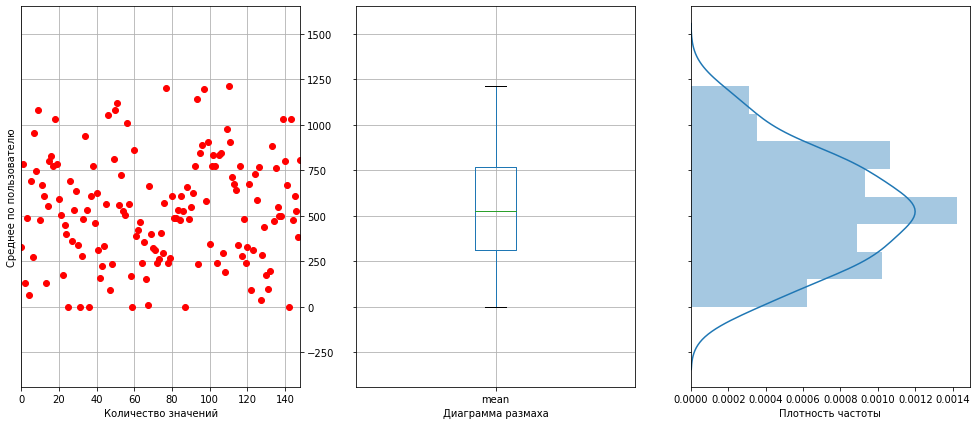

In [52]:
plots_and_values(ultra_users_calls, 'mean')

У клиентов тарифа "Ультра" наблюдаем несколько иную картину:

- По звонкам среднее и медиана, также как и в случае с тарифом "Смарт" почти равны и расстояние от медианы до первого и третьего квартиля также почти равны, поэтому можно судить о нормальном распределении без каких-либо сдвигов;

- А вот из диаграммы размаха видно отсутствие аномальной высоких и низких значений;

- 95% значений находится в доверительном интервале от 0 до 1122.9 минут в месяц

### Интернет-траффик

Нижний квартиль: 13597.0 
Верхний квартиль: 18571.3 
Нижний "ус": 6794.0 
Верхний "ус": 25653.0 
Медиана: 16197.0
Среднее: 16029.5 
Дисперсия: 14379029.9 
Стандартное отклонение: 3792.0, интервал 95% [-2σ: +2σ]: 8445.6 - 23613.5


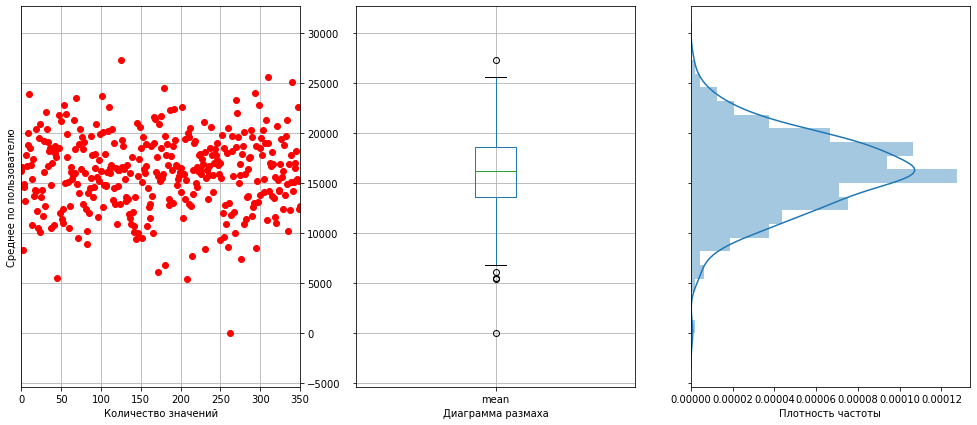

In [53]:
plots_and_values(smart_users_inet, 'mean')

У клиентов тарифа "Смарт" наблюдаем следующую картину:

- По интернет-траффику среднее и медиана почти равны и расстояние от медианы до первого и третьего квартиля также почти равны, поэтому можно судить о нормальном распределении без каких-либо сдвигов;

- Из диаграммы размаха следует, что присутствуют аномально низкие значения (меньше 6794 Мб) и аномально высокие значения (больше 25653Мб) в месяц соответственно;

- 95% значений находится в доверительном интервале от 8445.6 до 23613.5 Мб в месяц

Нижний квартиль: 13417.0 
Верхний квартиль: 25724.0 
Нижний "ус": 0.0 
Верхний "ус": 38502.0 
Медиана: 18249.0
Среднее: 19152.8 
Дисперсия: 71946841.9 
Стандартное отклонение: 8482.1, интервал 95% [-2σ: +2σ]: 2188.5 - 36117.1


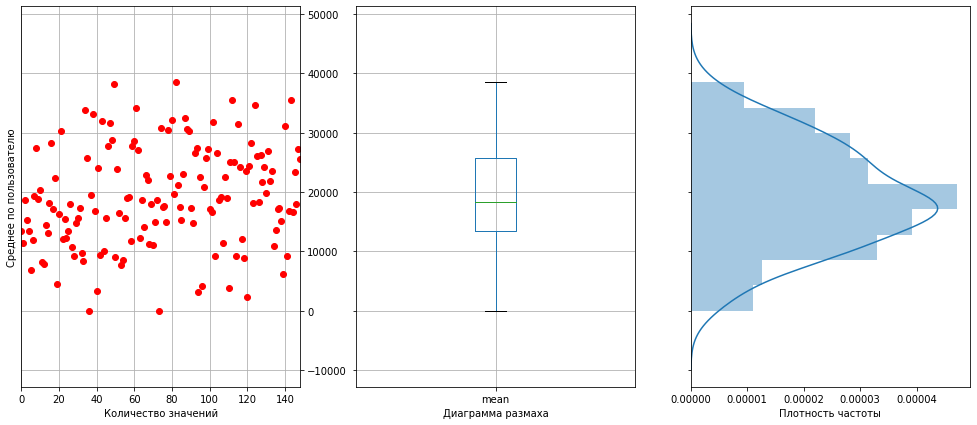

In [54]:
plots_and_values(ultra_users_inet, 'mean')

У клиентов тарифа "Ультра" наблюдаем несколько иную картину:

- По интернет-траффику среднее и медиана, также как и в случае с тарифом "Смарт" почти равны и расстояние от медианы до первого и третьего квартиля также почти равны (есть небольшой сдвиг к третьему квартилю), поэтому можно судить о нормальном распределении с небольшим положительным сдвигом;

- А вот из диаграммы размаха видно отсутствие аномальной высоких и низких значений;

- 95% значений находится в доверительном интервале от  2188.5 до 36117.1 Мб в месяц

### Сообщения

Нижний квартиль: 11.0 
Верхний квартиль: 48.0 
Нижний "ус": 0.0 
Верхний "ус": 99.0 
Медиана: 27.0
Среднее: 32.0 
Дисперсия: 703.3 
Стандартное отклонение: 26.5, интервал 95% [-2σ: +2σ]: -21.0 - 85.1


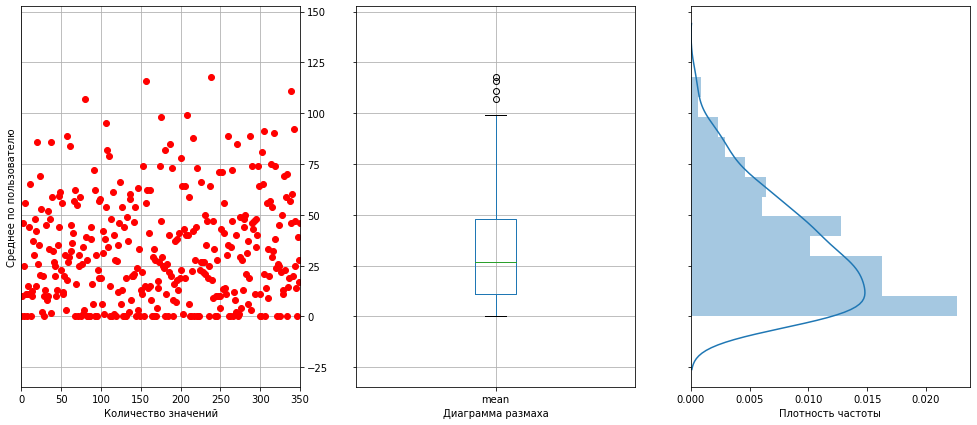

In [55]:
plots_and_values(smart_users_sms, 'mean')

У клиентов тарифа "Смарт" наблюдаем следующую картину:

- По сообщениям среднее и медиана почти равны и расстояние от медианы до первого и третьего квартиля также почти равны, поэтому можно судить о нормальном распределении без каких-либо сдвигов;

- Из диаграммы размаха следует, что присутствуют только аномально высокие значения (больше 99 сообщений) в месяц;

- 95% значений находится в доверительном интервале от 0 до 85 сообщений в месяц

Нижний квартиль: 14.0 
Верхний квартиль: 82.0 
Нижний "ус": 0.0 
Верхний "ус": 176.0 
Медиана: 44.0
Среднее: 53.1 
Дисперсия: 2161.2 
Стандартное отклонение: 46.5, интервал 95% [-2σ: +2σ]: -39.8 - 146.1


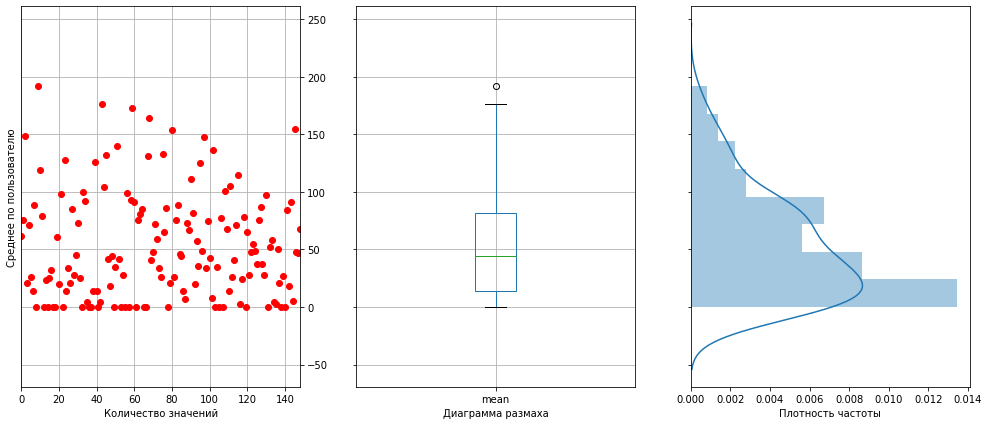

In [56]:
plots_and_values(ultra_users_sms, 'mean')

У клиентов тарифа "Ультра" наблюдаем несколько иную картину:

- По сообщениям среднее и медиана немного отличаются, а расстояние от медианы до первого квартиля чуть больше расстояния до третьего квартиля. В целом можно судить о нормальном распределении без сильных сдвигов;

- Из диаграммы размаха следует, что присутствуют только аномально высокие значения (больше 176 сообщений) в месяц;

- 95% значений находится в доверительном интервале от 0 до 146 сообщений в месяц

Напишем функцию tariff_compare, представляющую 2 тарифа на одном графике для звонков, сообщений и интернет трафика.



In [57]:
def tariff_compare(df1, df2, column):
    plt.figure(figsize=(10,5))
    sns.distplot(df1[column], color='r').set(xlabel='Среднее по пользователю', ylabel='Плотность частоты');
    sns.distplot(df2[column], color='b').set(xlabel='Среднее по пользователю', ylabel='Плотность частоты');

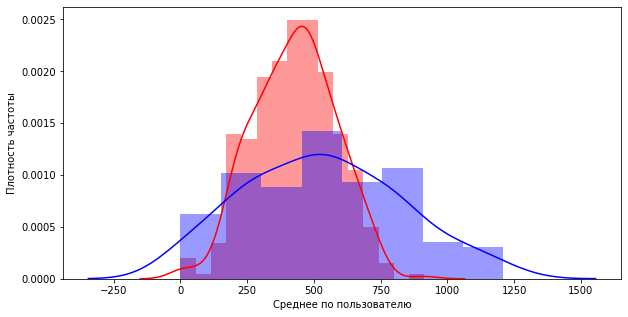

In [58]:
tariff_compare(smart_users_calls, ultra_users_calls, 'mean')

- Для тарифа "Смарт": среднее: 427.2, стандартное отклонение: 152.9, интервал 95% [-2σ: +2σ]: [121.3 : 733.0]
- Для тарифа "Ультра": среднее: 531.9, стандартное отклонение: 295.5, интервал 95% [-2σ: +2σ]: [0 : 1122.9]

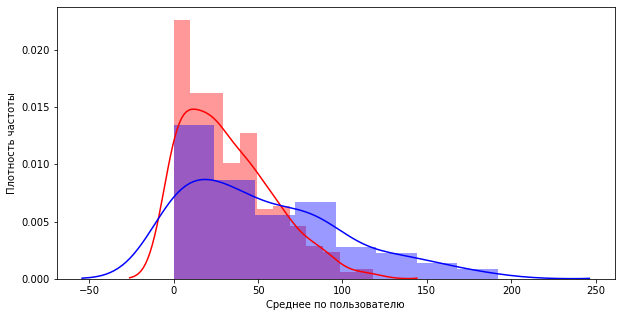

In [59]:
tariff_compare(smart_users_sms, ultra_users_sms, 'mean')

- Для тарифа "Смарт": среднее: 32.0, стандартное отклонение: 26.5, интервал 95% [-2σ: +2σ]: [0 : 85.1]
- Для тарифа "Ультра": среднее: 53.1, стандартное отклонение: 46.5, интервал 95% [-2σ: +2σ]: [0 : 146.1]

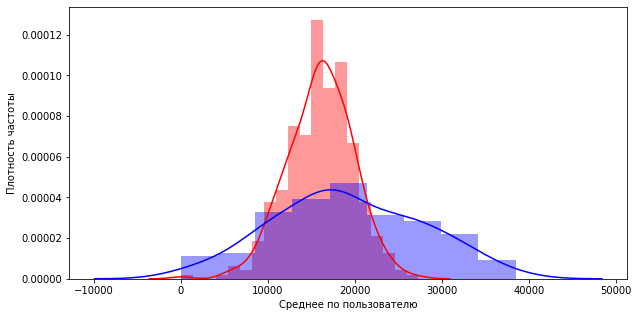

In [60]:
tariff_compare(smart_users_inet, ultra_users_inet, 'mean')

- Для тарифа "Смарт": среднее: 16029.5, стандартное отклонение: 3792.0, интервал 95% [-2σ: +2σ]: [8445.6 : 23613.5]
- Для тарифа "Ультра": среднее: 19152.8, стандартное отклонение: 8482.1, интервал 95% [-2σ: +2σ]: [2188.5 : 36117.1]

### Выводы:

- Исходя из условий, **по тарифному плану "Смарт"** включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. Для пользователей этого тарифа в среднем необходимо: 427 минут, 32 сообщения и 16029 Мб интернет-трафика. Исходя из доверительных интервалов, можно сделать следующий вывод: для половины пользователей 500 минут звонков недостаточно, 50 сообщений для большей части хватает, 15 Гб интернет-трафика хватает примерно половине пользователей.

- Исходя из условий, **по тарифному плану "Ультра"** включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика. Для пользователей этого тарифа в среднем необходимо: 532 минут, 53 сообщения и 19152 Мб интернет трафика. Исходя из доверительных интервалов, можно сделать следующий вывод: 3000 минут звонков достаточно для пользователей, 1000 достаточно для пользователей, 30 Гб интернет-трафика удовлетворяет большей половине пользователей.




## Проверка гипотез

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Произведем расчет средней выручки для каждого пользователя тарифа и добавим в новый столбец mean:

In [61]:
smart_general['mean'] = sum(smart_general[str(i) +'_total'] for i in range(1, 13)) / (13 - smart_general['registration_month'])
ultra_general['mean'] = sum(ultra_general[str(i) +'_total'] for i in range(1, 13)) / (13 - ultra_general['registration_month'])
smart_general

,user_id,tariff,registration_month,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total,mean
0,1001,smart,11,0,0,0,0,0,0,0,0,0,0,1153,550,851.500000
1,1002,smart,6,0,0,0,0,0,550,987,1524,814,550,1184,1092,957.285714
2,1005,smart,1,550,550,928,1258,868,919,820,970,556,1285,739,901,862.000000
3,1006,smart,2,0,550,930,550,550,550,1456,1324,585,1401,550,1162,873.454545
4,1007,smart,4,0,0,0,550,1008,724,879,1597,1072,550,1033,550,884.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0,0,0,0,0,0,0,550,897,1025,1080,996,909.600000
347,1496,smart,1,550,3438,2637,1778,2186,1704,2590,2310,2817,3060,2978,1706,2312.833333
348,1497,smart,10,0,0,0,0,0,0,0,0,0,568,550,1618,912.000000
349,1498,smart,7,0,0,0,0,0,0,550,2326,1879,1574,550,550,1238.166667


Найдем средную выручку для тарифов «Смарт» и «Ультра»:

In [62]:
smart_general['mean'].mean()

1277.981913045802

In [63]:
ultra_general['mean'].mean()

2072.1497728967524

Сформируем нулевую гипотезу H₀ - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны". Тогда альтернативная гипотеза H₁ формирует следующие утверждение: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

In [64]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

#results = st.ttest_ind(smart_general['mean'], ultra_general['mean'], equal_var = False)
results = st.ttest_ind(smart_general[str(i) +'_total'], ultra_general[str(i) +'_total'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.806623057382979e-20
Отвергаем нулевую гипотезу


In [65]:
smart_general[str(i) +'_total'].head()

0     550
1    1092
2     901
3    1162
4     550
Name: 12_total, dtype: int64

Полученное p-значение позволяет отвергнуть нулевую гипотезу и говорит о том, что "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается", выручка от тарифа «Ультра» выше, чем у тарифа «Смарт».
Получить подтверждение нулевой гипотезы ничтожно мало(гораздо меньше критического уровеня статистической значимости в 0.05).

### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Вызовем датафрейм data_users:

In [66]:
data_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2018-12-31,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2018-12-31,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2018-12-31,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Создадим срез user_age_city по id и городу пользователя

In [67]:
user_age_city = data_users.loc[:, ['user_id', 'city']]
user_age_city

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк
...,...,...
495,1495,Иркутск
496,1496,Вологда
497,1497,Челябинск
498,1498,Владикавказ


Создадим срез smart_total_mean и ultra_total_mean по id и доходу от пользователя. Объединим в общую таблицу с добавлением столбца mean:

In [68]:
smart_total_mean = smart_general.loc[:, ['user_id', 'mean']]
ultra_total_mean = ultra_general.loc[:, ['user_id', 'mean']]
total_mean =  (user_age_city.merge(smart_total_mean, on='user_id', how='left')
                            .merge(ultra_total_mean, on='user_id', how='left')
              ).fillna(0)
total_mean['mean'] = total_mean['mean_x'] + total_mean['mean_y']
total_mean

,user_id,city,mean_x,mean_y,mean
0,1000,Краснодар,0.000000,1950.0,1950.000000
1,1001,Москва,851.500000,0.0,851.500000
2,1002,Стерлитамак,957.285714,0.0,957.285714
3,1003,Москва,0.000000,1950.0,1950.000000
4,1004,Новокузнецк,0.000000,1950.0,1950.000000
...,...,...,...,...,...
495,1495,Иркутск,0.000000,2261.4,2261.400000
496,1496,Вологда,2312.833333,0.0,2312.833333
497,1497,Челябинск,912.000000,0.0,912.000000
498,1498,Владикавказ,1238.166667,0.0,1238.166667


Создадим 2 среза по пользователям: Москва и остальные регионы

In [69]:
total_mean_moscow = total_mean.query('city == "Москва"')
total_mean_other = total_mean.query('city != "Москва"')
total_mean_other

,user_id,city,mean_x,mean_y,mean
0,1000,Краснодар,0.000000,1950.0,1950.000000
2,1002,Стерлитамак,957.285714,0.0,957.285714
4,1004,Новокузнецк,0.000000,1950.0,1950.000000
5,1005,Набережные Челны,862.000000,0.0,862.000000
6,1006,Ульяновск,873.454545,0.0,873.454545
...,...,...,...,...,...
495,1495,Иркутск,0.000000,2261.4,2261.400000
496,1496,Вологда,2312.833333,0.0,2312.833333
497,1497,Челябинск,912.000000,0.0,912.000000
498,1498,Владикавказ,1238.166667,0.0,1238.166667


Посчитаем средную выручку для Москвы и остальных регионов:

In [70]:
total_mean_moscow['mean'].mean()

1469.1888466191497

In [71]:
total_mean_other['mean'].mean()

1525.8660145271745

Сформируем нулевую гипотезу H₀ - "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов". Тогда альтернативная гипотеза H₁ формирует следующие утверждение: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

In [72]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(total_mean_moscow['mean'], total_mean_other['mean'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4110446269583852
Не получилось отвергнуть нулевую гипотезу


Полученное p-значение не позволяет отвергнуть нулевую гипотезу и говорит о том, что "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов". С вероятностью в 41% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками в Москве и других регионах.

### Выводы:
- Проверка первой гипотезы показала, что средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается и на тарифе «Ультра» почти в 2 раза выше, что предполагает о таком же распределение в генеральной совокупности;

- Проверка второй гипотезы показала, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, что предполагает такое же распределение в генеральной совокупности.


## Общий вывод

**Проанализировав данные, мы выполнили несколько важных этапов:**

- Получили общую информацию о файлах и структуре;
- Привели данные в необходимый для исследования формат;
- Выполнили анализ данных: дали описание клиентов на основе выборки. Рассчитали среднее, дисперсию и стандартное отклонение по длительности звонков, расходу интернет-трафика, а также количеству отправленных смс-сообщений. Построили гистограммы и описали распределения;
- Произвели проверку статистических гипотез.

**На основе всех вышеперечисленных этапов мы можем судить о следующем:**

- **тариф "Смарт"** - для половины пользователей 500 минут звонков недостаточно , 50 сообщений для большей части хватает, 15 Гб интернет-трафика хватает примерно половине пользователей;

- **тариф "Ультра"** - 3000 минут звонков достаточно для пользователей, 1000 достаточно для пользователей, 30 Гб интернет-трафика удовлетворяет большую часть пользователей;

- Из-за перерасхода минут и интернет-трафика на тарифе "Смарт", для большинства пользователей **более оптимальным будет тариф "Ультра"**;

- В среднем выручка от пользователей тарифов «Ультра» и «Смарт» различается почти в 2 раза. Для компании это перспективный тариф и на нем следует сфокусировать рекламный бюджет. Плюс, пользователи будут более охотно переходить на новый тариф, если по старому постоянно присутствует перерасход денежных средств.



